In [12]:
import glob
import xarray as xr
import numpy as np
from tqdm import tqdm

#Functions

def get_global_weights():
    
     #Get the latitude weights from a special location
    r1 = '/network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/speedyone/paper/Fig1_10year_Williams/'
    f = r1 + 'speedyoneWILLIAMS_L2_52_RN_10y/model_output00001.nc'
    df = xr.open_dataset(f)
    
    temp_file = df.temperature
    weights = np.cos(np.deg2rad(temp_file.latitude))
         
    weights.name = "weights"
    
    
    return weights, temp_file.latitude


import pandas as pd
def extract_file_info(d):
    
    #Mapping between levels
    level_dict = {'L1': 'El Nino Static SST. ablco2=6',
                  'L2': 'EC Earth SST. ablco2=6',
                  'L3': 'El Nino Static SST. ablco2=21',
                  'L4': 'EC Earth SST. ablco2=21'
                  }

    #Create some useful labels
    label = d.split('/')[-1]
    level = label.split('_')[1]
    prec = label.split('_')[2]
    rounding = label.split('_')[3]
    title = level_dict[level]
    
    keys = ['label', 'level', 'precision','title']
    values = [label,level,prec+'_'+rounding,title]
    dictionary = {keys[i]: values[i] for i in range(len(keys))}
    
    return dictionary




def surface_slice(y,weights):
    
 
    #Get values at surface
    y_surface =  y[:,0]   
    ygrid = y_surface.weighted(weights).mean(("longitude", "latitude")).data #average across every surface grid point


    return ygrid


def extract_file_data(df,columns,weights):
    
    
    data = [surface_slice(getattr(df,
                                  columns[k]),
                                   weights = weights) for k in range(len(columns))]
    
    
    dictionary = {columns[i]: data[i] for i in range(len(columns))}
    df_out = pd.DataFrame(dictionary)
    
    
    return df_out

    
    
def process_nc_file(fname,weights,directory,true_lat):    
    
        #Get data 
        df = xr.open_dataset(fname)
        
        
        #Reset the latitude
        df = df.assign_coords(latitude=(true_lat))
        

       
        #Get the data you want     
        columns_3d  = ['temperature']
        data3d = extract_file_data(df,columns_3d,weights)

                
        #Get meta information
        f_info = extract_file_info(directory)
        index = data3d.index
        df_info = pd.DataFrame(f_info,index=index)
      
        #Create pandas df and append
        df_meta = pd.concat([data3d,df_info,],axis=1) 
        
        return df_meta
    
    
def process_all_data(all_directories,weights,true_lat):

    
    #Empty arrays to hold data
    dfs = []
    for d in all_directories: #for every directory
        
        print ('directory',d)
        df_LI = [] # df of solution level i
        nc_files = sorted(glob.glob(d+'/**/*model_output*.nc',recursive=True))
        counter = 0
        #for n in tqdm(nc_files[0:100]): #for every model.nc file
        #for n in nc_files[0:100]:
        for n in tqdm(nc_files):
           # 
            df_meta = process_nc_file(n,weights,d,true_lat)
            #print('File', counter , n,df_meta.shape)
            if df_meta.shape == (365,5):
                df_LI.append(df_meta)
                counter += 1
        
        df_LI = pd.concat(df_LI,ignore_index=True)
        df_LI['X'] = np.arange(len(df_LI))
        
        #Add append to bigger array
        dfs.append(df_LI)
            
    #Bring all together
    df = pd.concat(dfs)
    
    return df #.reset_index()



def process_node(node,fname):
    
    print ('--------------------------')
    print ('Processing', node, fname)

    #Parameters
    root= '/network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/speedyone/'
    
    header_directories = glob.glob(root+node+'speedyone10yr*')


    #Get the global weights
    weights,true_lat = get_global_weights()


    #Iterate over all directories
    df = process_all_data(header_directories,weights,true_lat)
    
    #save it
    pd.to_pickle(df,fname)
    
    return df


                 

# Process all ensemble members

In [33]:
#node = 'paper/10year_mixed_precision_solutions/tmp2/'
node = 'paper/10year_mixed_precision_solutions/'

fname = 'explore_example.pkl'
df1 = process_node(node,fname)

--------------------------
Processing paper/10year_mixed_precision_solutions/ explore_example.pkl
directory /network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/speedyone/paper/10year_mixed_precision_solutions/speedyone10yr_L2_10_RNcpl_m5_W15


100%|██████████| 11/11 [00:00<00:00, 14.51it/s]


directory /network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/speedyone/paper/10year_mixed_precision_solutions/speedyone10yr_L2_10_RNstloop5_m5_W15


100%|██████████| 11/11 [00:00<00:00, 14.83it/s]


In [34]:
#node = 'paper/10year_mixed_precision_solutions/tmp2/'
node = 'paper/10year_mixed_precision_solutions/unchange/'

fname = 'explore_example.pkl'
df2 = process_node(node,fname)

--------------------------
Processing paper/10year_mixed_precision_solutions/unchange/ explore_example.pkl
directory /network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/speedyone/paper/10year_mixed_precision_solutions/unchange/speedyone10yr_L2_10_RNagcm_m5_W15


100%|██████████| 11/11 [00:00<00:00, 14.75it/s]


directory /network/group/aopp/predict/TIP016_PAXTON_RPSPEEDY/speedyone/paper/10year_mixed_precision_solutions/unchange/speedyone10yr_L2_10_RNstloop_m5_W15


100%|██████████| 11/11 [00:00<00:00, 14.75it/s]


In [39]:
import seaborn as sns
import matplotlib.pyplot as plt
def calculate_residuals(df):
    
    
    #Get a ground truth that all others will be compared against. i.e. 52 RNe
    df_truth = df.query('precision == "52_RN" ')[['X', 'temperature']]
    df_truth['merge_column'] = df_truth['X'].astype(int) #Create a column to merge on.     #Note integer conversions are needed for join

    
    #Get the others
    df_rest = df.query('precision != "52_RN" ').reset_index(drop=True) #reset index to avoid SettingWithCopyWarning
    df_rest['merge_column'] = df_rest['X'].astype('int') 
    

    #Rejoin - maybe a more efficient way to do this?
    df_join = pd.merge(df_rest,df_truth,how='left',on='merge_column', suffixes=(None, 'truth'))
    
    #Get residual
    df_join['MBE'] = df_join['temperature'] - df_join['temperaturetruth']
    df_join['MAE'] = abs(df_join['temperature'] - df_join['temperaturetruth'])
    
    print ('Average:')
    display(df_join.groupby(by=["precision"]).mean()) 
    display(len(df_join))
    return df_join

def plot_timeseries(df,time_period,title,savefig):
    
    #Take an average over time_period number of days. Set time_period = 365 for yearly average
    df_averaged = df.groupby([df.index//time_period, 'label','level','precision', 'title'],as_index=False).mean()
    df_averaged['years'] =  df_averaged['X'] / 365 #Convert from days to years
    
    #Get the residuals of the averaged df
    df_residuals = calculate_residuals(df_averaged)
    
    #Setup plot configuration
    h,w = 20,20

    sns.set_theme(context='talk', 
                  style='ticks', 
                  palette='deep',
                  rc={'figure.figsize':(h,w)}
                  )

    fig, (ax1,ax2) = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(h,w))

   
    
    
    #Plot the timeseries
    p = sns.lineplot(data=df_averaged, x="years", y='temperature', hue="precision",ax=ax1,style='precision',markers=True)
    
    #Plot the residuals
    q = sns.lineplot(data=df_residuals, x="years", y='MBE', hue="precision",ax=ax2,style='precision',markers=False,legend=None)

    #Config
    plt.subplots_adjust(wspace=0.1, hspace=0)

    ax1.set_ylabel("Global Mean Surface Temperature (K)")
    ax2.set_ylabel("Mean Bias Error(K)")

    
    ax2.set_xlabel("Time (years)")
    ax2.axhline(0.0, c='0.5', linestyle='--')
    #ax2.set_yscale('log')
    
    ax1.set_ylim(288,290)
    ax1.set_title(title)
    
    
    if savefig is not None:
        plt.savefig(savefig,bbox_inches='tight', pad_inches=0, dpi=300)

    #Other config
    ax1.legend().set_title(None)
    
    
    

In [40]:
df_og = pd.read_pickle('m5_example.pkl')

In [41]:
df_og.query('precision == "10_RN"')

,temperature,label,level,precision,title,X
0,286.025455,speedyone100yr_L2_10_RN_m5,L2,10_RN,EC Earth SST. ablco2=6,0
1,286.732497,speedyone100yr_L2_10_RN_m5,L2,10_RN,EC Earth SST. ablco2=6,1
2,286.952637,speedyone100yr_L2_10_RN_m5,L2,10_RN,EC Earth SST. ablco2=6,2
3,287.079776,speedyone100yr_L2_10_RN_m5,L2,10_RN,EC Earth SST. ablco2=6,3
4,287.197223,speedyone100yr_L2_10_RN_m5,L2,10_RN,EC Earth SST. ablco2=6,4
...,...,...,...,...,...,...
36495,291.630534,speedyone100yr_L2_10_RN_m5,L2,10_RN,EC Earth SST. ablco2=6,36495
36496,291.626984,speedyone100yr_L2_10_RN_m5,L2,10_RN,EC Earth SST. ablco2=6,36496
36497,291.641370,speedyone100yr_L2_10_RN_m5,L2,10_RN,EC Earth SST. ablco2=6,36497
36498,291.639307,speedyone100yr_L2_10_RN_m5,L2,10_RN,EC Earth SST. ablco2=6,36498


In [42]:
df

,temperature,label,level,precision,title,X
0,286.025455,speedyone10yr_L2_10_RNcpl_m5_W15,L2,10_RNcpl,EC Earth SST. ablco2=6,0
1,286.732497,speedyone10yr_L2_10_RNcpl_m5_W15,L2,10_RNcpl,EC Earth SST. ablco2=6,1
2,286.983538,speedyone10yr_L2_10_RNcpl_m5_W15,L2,10_RNcpl,EC Earth SST. ablco2=6,2
3,287.141749,speedyone10yr_L2_10_RNcpl_m5_W15,L2,10_RNcpl,EC Earth SST. ablco2=6,3
4,287.261131,speedyone10yr_L2_10_RNcpl_m5_W15,L2,10_RNcpl,EC Earth SST. ablco2=6,4
...,...,...,...,...,...,...
3645,289.605907,speedyone10yr_L2_10_RNstloop5_m5_W15,L2,10_RNstloop5,EC Earth SST. ablco2=6,3645
3646,289.538365,speedyone10yr_L2_10_RNstloop5_m5_W15,L2,10_RNstloop5,EC Earth SST. ablco2=6,3646
3647,289.503592,speedyone10yr_L2_10_RNstloop5_m5_W15,L2,10_RNstloop5,EC Earth SST. ablco2=6,3647
3648,289.500937,speedyone10yr_L2_10_RNstloop5_m5_W15,L2,10_RNstloop5,EC Earth SST. ablco2=6,3648


Average:


,temperature,X,years,merge_column,Xtruth,temperaturetruth,MBE,MAE
precision,,,,,,,,
10_RN,289.148272,1824.5,4.99863,1824.5,1824.5,289.256493,-0.108221,0.108221
10_RNagcm,289.142111,1824.5,4.99863,1824.5,1824.5,289.256493,-0.114382,0.114382
10_RNcpl,289.262395,1824.5,4.99863,1824.5,1824.5,289.256493,0.005902,0.021160
10_RNstloop,289.134144,1824.5,4.99863,1824.5,1824.5,289.256493,-0.122349,0.122349
10_RNstloop5,289.117509,1824.5,4.99863,1824.5,1824.5,289.256493,-0.138984,0.138984
10_SR,289.235567,1824.5,4.99863,1824.5,1824.5,289.256493,-0.020926,0.020926
23_RN,289.253485,1824.5,4.99863,1824.5,1824.5,289.256493,-0.003007,0.023323


70

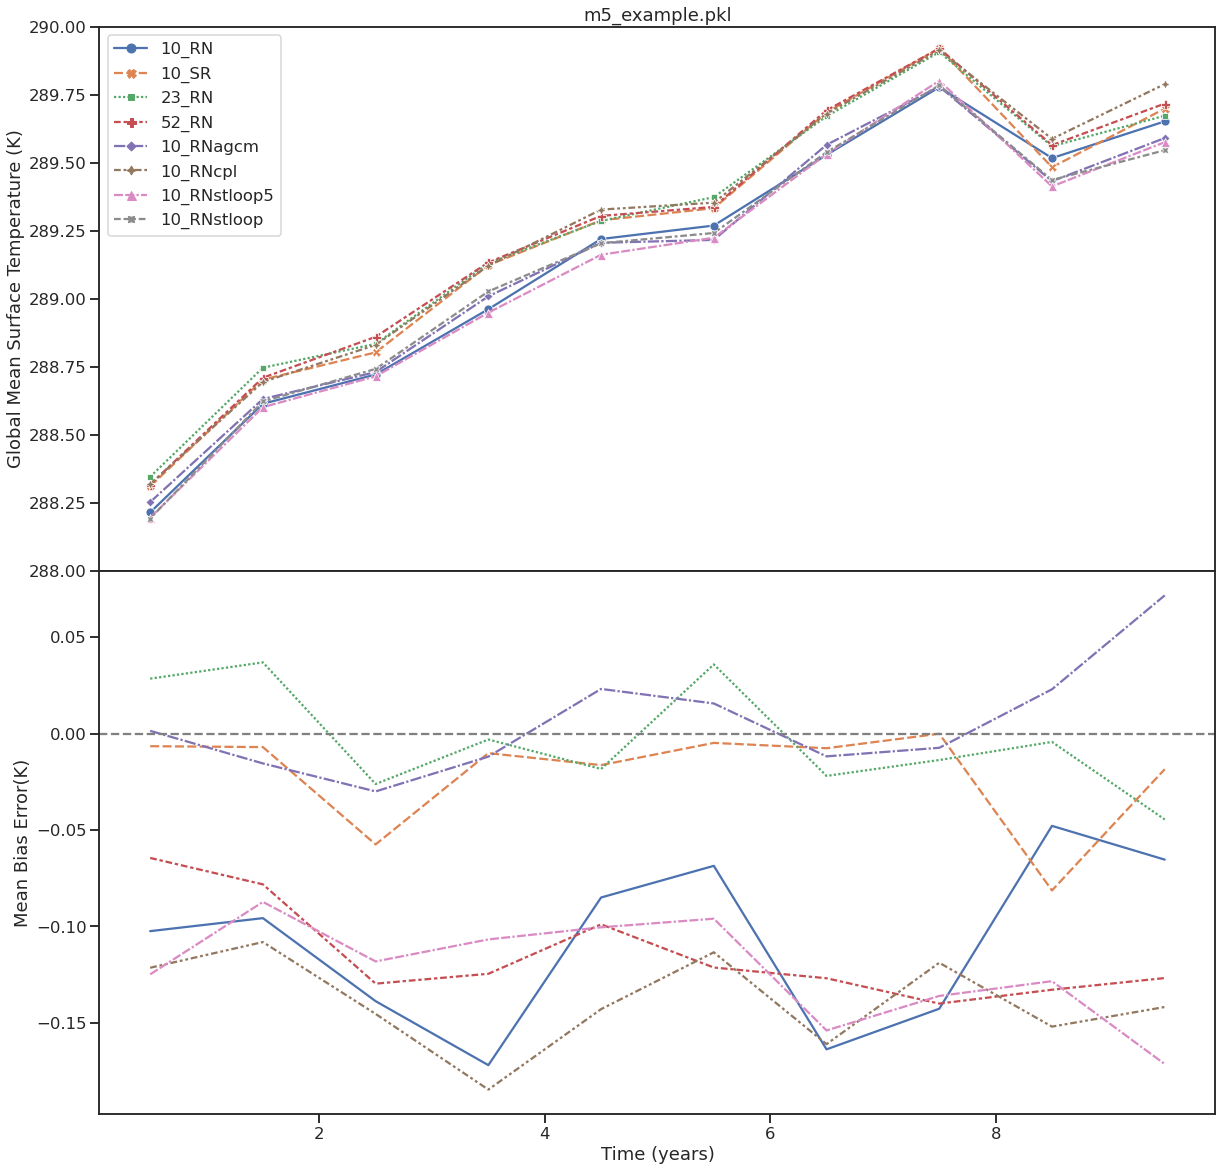

In [43]:

timeseries_files = [f'm5_example.pkl'] 

for m in timeseries_files:
    dtmp = pd.read_pickle(m)
    df10year = dtmp.query('X <= 3649')
    
    dfplot = pd.concat([df10year,df1,df2])
    #display(dfplot)
    plot_timeseries(dfplot,time_period=365,title=m,savefig=None)

In [44]:
plot_timeseries(dfplot,time_period=365)

TypeError: plot_timeseries() missing 2 required positional arguments: 'title' and 'savefig'

In [44]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_config(ax1,ax2,save):
    

    #Config
    plt.subplots_adjust(wspace=0.1, hspace=0)

    ax1.set_ylabel("Gloabl Mean Surface Temperature (K)")#, fontsize = 20)
    ax2.set_ylabel("Absolute Error (K)")#, fontsize = 20)


    ax2.set_xlabel("Time (years)")#, fontsize = 20)
    ax2.axhline(0.0, c='0.5', linestyle='--')
    

   # ax1.set_xlim(0,400)
    ax1.set_ylim(288,292.5)

    #Other config
    ax1.legend().set_title(None)
    
    if save:
        plt.savefig('figs/Fig1_Williams.png', dpi=300, bbox_inches='tight')


    
    
def get_relative_error_df(df):
    
    
    #Get a ground truth that all others will be compared against
    df_truth = df.query('precision == "52_RN" ')[['X', 'temperature']]
    df_truth['merge_column'] = df_truth['X'].astype(int)
    
    #Get the others
    df_rest = df.query('precision != "52_RN" ').reset_index(drop=True) #rest index to avoid SettingWithCopyWarning
    df_rest['merge_column'] = df_rest['X'].astype('int') 
    
    #Note integer conversions are needed for join

    #Rejoin - maybe a more efficient way to do this?
    df_join = pd.merge(df_rest,df_truth,how='left',on='merge_column', suffixes=(None, 'truth'))
    
    
    #Get the absolute error
    #df_join['error']  = df_join['temperature'] - df_join['temperaturetruth']
    df_join['error']  = abs(df_join['temperature'] - df_join['temperaturetruth'])/df_join['temperaturetruth']

    
    return df_join
    
def plot_error_timeseries(df1,df2,save_it):
    
    #Setup plot env
    h,w = 20,20

    sns.set_theme(context='talk', 
                  style='ticks', 
                  palette='deep',
                  rc={'figure.figsize':(h,w)}
                  )

    

    
    fig, (ax1,ax2) = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(h,w))
    
    df1['years'] = df1.X/365
    
    
    #Plot the df directly
    p = sns.lineplot(data=df1, x="years", y='temperature', hue="precision",ax=ax1,style='precision',markers=True)


    #Calculate the relative_error df and plot
    df_error = get_relative_error_df(df1)
    #df_error['years'] = df2.X #/365

    df_error['years'] = df_error['X']/365
    
    decadal_window = 1 #take an average over N years
    df_error_decadal = df_error.groupby([df_error.years//decadal_window, 'label','level','precision', 'title'],as_index=False).mean()
    p = sns.lineplot(data=df_error_decadal, x="years", y='error', hue="precision",ax=ax2,style='precision',markers=True,legend=None)


    plot_config(ax1,ax2,save_it)

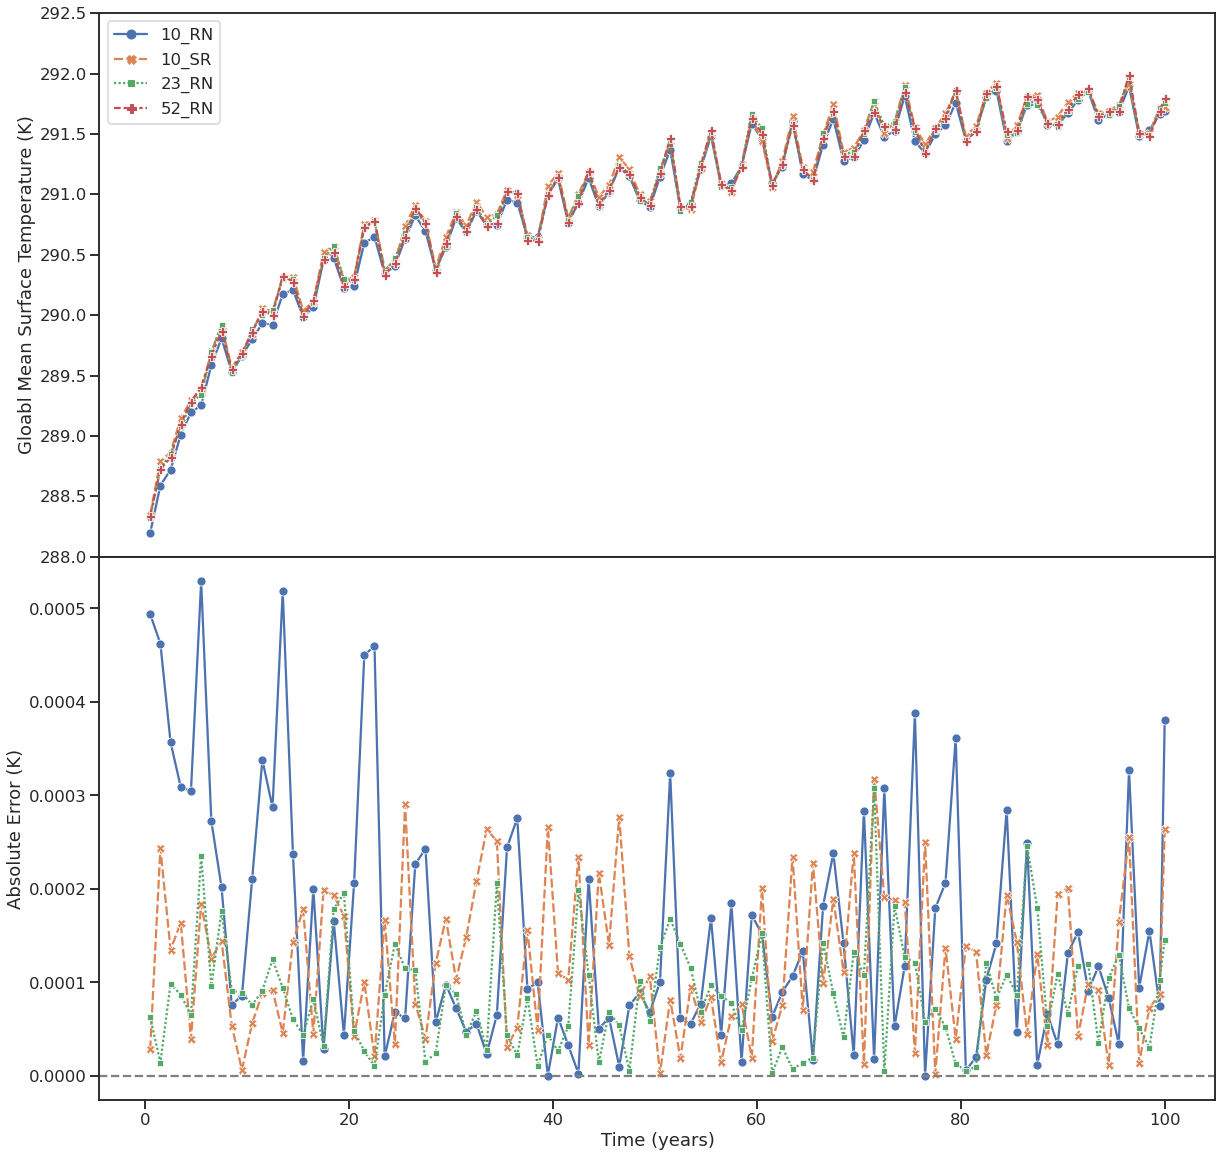

In [19]:
save_it = True #Do you want to save the Fig?
plot_error_timeseries(df_annual_mean,df_decadal_mean,save_it)

In [23]:
df_decadal_mean['years'] = df_decadal_mean.X/365 

In [21]:
df_error = get_relative_error_df(df_annual_mean)
